In [25]:
px = [[Bool(f'px_{i}_{e}') for e in [0,1,2,3]] for i in [0,1]]

s = Solver()

s.add(Not(px[1][0]))
s.add(Or(Not(px[1][1]),px[0][0]))
s.add(Or(Not(px[1][2]),px[0][1]))
s.add(px[0][2])

s.add(Or(Not(px[0][0]),px[0][1]))
s.add(Or(Not(px[0][1]),px[0][2]))
s.add(Or(Not(px[1][0]),px[1][1]))
s.add(Or(Not(px[1][1]),px[1][2]))

In [26]:
s.check()

sat

In [27]:
s.model()

[px_0_1 = False,
 px_1_0 = False,
 px_1_1 = False,
 px_0_2 = True,
 px_0_0 = False,
 px_1_2 = False]

In [187]:
import argparse

from z3 import *

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib.collections import PatchCollection

import random

#python scripts\visualize.py solution-ins-12.txt

def visualize(w, l, n, dims, coords):
    coordsX = [coords[i][0] for i in range(n)]
    coordsY = [coords[i][1] for i in range(n)]
    # print(w, l, n, dims, coordsX, coordsY)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    plt.xlim(0, w)
    plt.ylim(0, l)
    plt.grid(True, color='black')

    myPatches = []
    # myColors = []

    for i in range(n):
        xi_hat = coordsX[i]
        yi_hat = coordsY[i]
        xi = dims[i][0]
        yi = dims[i][1]

        r = patches.Rectangle((xi_hat, yi_hat), xi, yi)
        myPatches.append(r)

    collection = PatchCollection(myPatches, cmap=mpl.cm.hsv, alpha=0.5, edgecolor='black', linewidth=4)
    collection.set_array(np.linspace(0, 254, n, dtype=int))
    #print(np.linspace(0, 200, n, dtype=int))
    collection.set_clim([0, 255])
    ax.add_collection(collection)

    plt.xticks(range(w+1))
    plt.yticks(range(l+1))

    plt.gca().set_aspect('equal', adjustable='box')

    # fig.savefig('figure.png')
    plt.show()
    
class UnsatError(BaseException):
    pass

In [198]:
"""w = 8
n = 4
dims = [[3, 3],
        [3, 5],
        [5, 3],
        [5, 5]]"""
"""w = 4
n = 2
dims = [[3, 3],
        [3, 5]]"""
w = 16
n = 10
dims = [[3, 3],
        [3, 4],
        [3, 5],
        [3, 6],
        [3, 7],
        [3, 8],
        [3, 10],
        [3, 12],
        [4, 7],
        [7, 9]]
"""w = 17
n = 12
dims = [[3, 3],
        [3, 4],
        [3, 5],
        [3, 6],
        [3, 7],
        [3, 8],
        [3, 9],
        [4, 3],
        [4, 8],
        [4, 14],
        [7, 3],
        [7, 6]]"""
dimsX = [dims[i][0] for i in range(n)]
dimsY = [dims[i][1] for i in range(n)]

areas = [dimsX[i]*dimsY[i] for i in range(n)]  # The areas of the circuits
A_tot = sum(areas)  # The overall area of all the given circuits
h_min = min(dimsY)  # The minimum height of a circuit
h_max = max(dimsY)  # The maximum height of a circuit
w_min = min(dimsX)  # The minimum width of a circuit
w_max = max(dimsX)  # The maximum width of a circuit
l_min = max([h_max, A_tot // w])  # The lower bound for the length
min_rects_per_row = w // w_max  # Minimum number of circuits per row
# max_rects_per_col = ceil(n / max([1, min_rects_per_row]))  # Maximum number of circuits per column
#l_max =  sum(sorted(dimsY)[n-max_rects_per_col:]) 
if min_rects_per_row==0:
    raise UnsatError('UNSAT')
sorted_dimsY = sorted(dimsY, reverse=True)  
if min_rects_per_row==1:
    l_max = sum(dimsY)
else:
    l_max = sum([sorted_dimsY[i] for i in range(n) if i % min_rects_per_row == 0])  # The upper bound for the length
    
# l_max = l_min

In [271]:
def __solve(l_max):
        """Solves the given VLSI instance, using the SAT encoding 3.

        It is an auxiliary method. Its aim is to solve the VLSI instance without performing optimization: any solution is 
        good.

        Parameters
        ----------
        w_min : int
            Minimum width of a circuit
        h_min : int
            Minimum height of a circuit
        l_min : int
            Lower bound of the length of the plate
        l_max : int
            Upper bound of the length of the plate

        Returns
        -------
        s: z3.z3.Solver
            The solver instance
        coords : list of list of list of z3.z3.BoolRef
            Boolean variables 'coord_i_j_k'.
            See `Notes`.
        lengths : list of list of z3.z3.BoolRef
            Boolean variables 'length_k_l'.
            See `Notes`.

        Notes
        ------
        The following boolean variables are used
        - circuit_i_j_k, where 'i' in [0,w-w_min+1], 'j' in [0,l_max-h_min+1], 'k' in [0,n]. 
          '(i,j)' represent two coordinates of the plate, 'k' represents a circuit.
          circuit_i_j_k is True IIF the circuit 'k' is present in the cell '(i,j)' of the plate.
        - coord_i_j_k, where 'i' in [0,w-w_min+1], 'j' in [0,l_max-h_min+1], 'k' in [0,n].
          '(i,j)' represent two coordinates of the plate, 'k' represents a circuit.
          coord_i_j_k is True IIF the left-bottom corner of the circuit 'k' is put in the cell '(i,j)' of the plate.
        - length_k_l, where 'k' in [0,n] and 'l' in [0,l_max-l_min+1].
          'k' represents a circuit, 'l' represents a length of the plate.
           length_k_l is True IIF the circuit 'k' uses the length 'l' of the plate.
           For going from an index 'l' of 'length_k_l' to the actual length: l+l_min-1.
           For going from an actual length 'l' to an index of 'length_k_l': l-l_min+1.

        """
        #w, n, dimsX, dimsY = self.w, self.n, self.dimsX, self.dimsY

        s = Solver()  # Solver instance

        px = [[Bool(f'px_{i}_{e}') for e in range(w)] for i in range(n)]
        py = [[Bool(f'py_{i}_{f}') for f in range(l_max)] for i in range(n)]
        lr = [[Bool(f'lr_{i}_{j}') for j in range(n)] for i in range(n)]
        ud = [[Bool(f'ud_{i}_{j}') for j in range(n)] for i in range(n)]
        
        """for i in range(n):
            s.add( Or(px[i]) )
            s.add( Or(py[i]) )"""

        for i in range(n):
            for e in range(w-dimsX[i]):  # TODO uno in meno
                s.add( Or(Not(px[i][e]),px[i][e+1]) )
            for e in range(w-dimsX[i],w):
                s.add(px[i][e])
                
            for f in range(l_max-dimsY[i]):
                s.add( Or(Not(py[i][f]),py[i][f+1]) )
            for f in range(l_max-dimsY[i],l_max):
                s.add(py[i][f])
                
        for i in range(n):
            for j in range(i+1,n):
                s.add( Or(lr[i][j],lr[j][i],ud[i][j],ud[j][i]) )
                if w-dimsX[i]-dimsX[j] < 0:
                    s.add( Not(lr[i][j]) )
                    s.add( Not(lr[j][i]) )
                else:
                    for e in range(dimsX[i]):
                        s.add( Or(Not(lr[i][j]),Not(px[j][e])) )
                    for e in range(dimsX[j]):
                        s.add( Or(Not(lr[j][i]),Not(px[i][e])) )
                    for e in range(w-dimsX[i]-dimsX[j]+1):
                        s.add( Or(Not(lr[i][j]), px[i][e], Not(px[j][e+dimsX[i]])) )
                        s.add( Or(Not(lr[j][i]), px[j][e], Not(px[i][e+dimsX[j]])) )
                    
                """if w-dimsX[i]-dimsX[j] < 0:
                    s.add( Not(lr[j][i]) )
                else:
                    for e in range(dimsY[i]):
                        s.add( Or(Not(lr[j][i]),Not(px[i][e])) )
                    for e in range(w-dimsX[j]-dimsX[i]+1):
                        s.add( Or(Not(lr[j][i]), px[j][e], Not(px[i][e+dimsX[j]])) )"""
                    
                if l_max-dimsY[i]-dimsY[j] < 0:
                    s.add( Not(ud[i][j]) )
                    s.add( Not(ud[j][i]) )
                else:
                    for f in range(dimsY[i]):
                        s.add( Or(Not(ud[i][j]),Not(py[j][f])) )
                    for f in range(dimsY[j]):
                        s.add( Or(Not(ud[j][i]),Not(py[i][f])) )
                    for f in range(l_max-dimsY[i]-dimsY[j]+1):
                        s.add( Or(Not(ud[i][j]), py[i][f], Not(py[j][f+dimsY[i]])) )
                        s.add( Or(Not(ud[j][i]), py[j][f], Not(py[i][f+dimsY[j]])) )
                    
                """if l_max-dimsY[i]-dimsY[j] < 0:
                    s.add( Not(ud[j][i]) )
                else:
                    for f in range(dimsY[j]):
                        s.add( Or(Not(ud[j][i]),Not(py[i][f])) )
                    for f in range(l_max-dimsY[j]-dimsY[i]+1):
                        s.add( Or(Not(ud[j][i]), py[j][f], Not(py[i][f+dimsY[j]])) )"""
                    
        if s.check() != sat:
            raise UnsatError('UNSAT')
        
        return s, px, py, lr, ud

In [272]:
h = 17
s, px, py, lr, ud = __solve(l_max=h)

In [273]:
m = s.model()

In [274]:
print(m.evaluate(lr[0][8], model_completion=True))
print(m.evaluate(lr[8][0], model_completion=True))
print(m.evaluate(ud[0][8], model_completion=True))
print(m.evaluate(ud[8][0], model_completion=True))

False
True
False
False


In [275]:
coordsX = []
for i in range(n):
    for e in range(w):
        if m.evaluate(px[i][e], model_completion=True):
            coordsX.append(e)
            print(px[i][e])
            break
coordsX

px_0_7
px_1_7
px_2_0
px_3_10
px_4_13
px_5_3
px_6_6
px_7_0
px_8_3
px_9_9


[7, 7, 0, 10, 13, 3, 6, 0, 3, 9]

In [276]:
coordsY = []
for i in range(n):
    for f in range(l_max):
        if m.evaluate(py[i][f], model_completion=True):
            coordsY.append(f)
            print(py[i][f])
            break
coordsY

py_0_14
py_1_10
py_2_0
py_3_11
py_4_10
py_5_2
py_6_0
py_7_5
py_8_10
py_9_0


[14, 10, 0, 11, 10, 2, 0, 5, 10, 0]

In [277]:
coords = zip(coordsX, coordsY)
coords = list(coords)
coords

[(7, 14),
 (7, 10),
 (0, 0),
 (10, 11),
 (13, 10),
 (3, 2),
 (6, 0),
 (0, 5),
 (3, 10),
 (9, 0)]

In [278]:
coords = []
for i in range(n):
    for e in range(w):
        if m.evaluate(px[i][e], model_completion=True):
            coordX = e
            break
    for f in range(l_max):
        if m.evaluate(py[i][f], model_completion=True):
            coordY = f
            break
    coords.append((coordX,coordY))

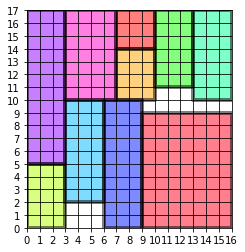

In [279]:
visualize(w, h, n, dims, coords)

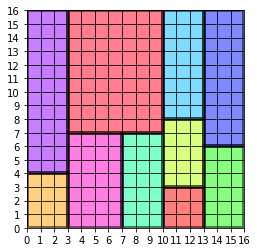

In [197]:
visualize(w, l_max, n, dims, coords)

In [337]:
def __solve(h):
        """Solves the given VLSI instance, using the SAT encoding 3.

        It is an auxiliary method. Its aim is to solve the VLSI instance without performing optimization: any solution is 
        good.

        Parameters
        ----------
        w_min : int
            Minimum width of a circuit
        h_min : int
            Minimum height of a circuit
        l_min : int
            Lower bound of the length of the plate
        l_max : int
            Upper bound of the length of the plate

        Returns
        -------
        s: z3.z3.Solver
            The solver instance
        coords : list of list of list of z3.z3.BoolRef
            Boolean variables 'coord_i_j_k'.
            See `Notes`.
        lengths : list of list of z3.z3.BoolRef
            Boolean variables 'length_k_l'.
            See `Notes`.

        Notes
        ------
        The following boolean variables are used
        - circuit_i_j_k, where 'i' in [0,w-w_min+1], 'j' in [0,l_max-h_min+1], 'k' in [0,n]. 
          '(i,j)' represent two coordinates of the plate, 'k' represents a circuit.
          circuit_i_j_k is True IIF the circuit 'k' is present in the cell '(i,j)' of the plate.
        - coord_i_j_k, where 'i' in [0,w-w_min+1], 'j' in [0,l_max-h_min+1], 'k' in [0,n].
          '(i,j)' represent two coordinates of the plate, 'k' represents a circuit.
          coord_i_j_k is True IIF the left-bottom corner of the circuit 'k' is put in the cell '(i,j)' of the plate.
        - length_k_l, where 'k' in [0,n] and 'l' in [0,l_max-l_min+1].
          'k' represents a circuit, 'l' represents a length of the plate.
           length_k_l is True IIF the circuit 'k' uses the length 'l' of the plate.
           For going from an index 'l' of 'length_k_l' to the actual length: l+l_min-1.
           For going from an actual length 'l' to an index of 'length_k_l': l-l_min+1.

        """
        #w, n, dimsX, dimsY = self.w, self.n, self.dimsX, self.dimsY
        
        if h<l_min:
            raise UnsatError('UNSAT')

        s = Solver()  # Solver instance
        s.set(timeout=1)

        px = [[Bool(f'px_{i}_{e}') for e in range(w)] for i in range(n)]
        py = [[Bool(f'py_{i}_{f}') for f in range(l_max)] for i in range(n)]
        lr = [[Bool(f'lr_{i}_{j}') for j in range(n)] for i in range(n)]
        ud = [[Bool(f'ud_{i}_{j}') for j in range(n)] for i in range(n)]
        
        ph = [Bool(f'ph_{o}') for o in range(l_max-l_min)]
        
        s.add( ph[h-l_min] )
        
        """for i in range(n):
            s.add( Or(px[i]) )
            s.add( Or(py[i]) )"""

        for i in range(n):
            for e in range(w-dimsX[i]):
                s.add( Or(Not(px[i][e]),px[i][e+1]) )
            for e in range(w-dimsX[i],w):
                s.add(px[i][e])
            for f in range(l_max-dimsY[i]):
                s.add( Or(Not(py[i][f]),py[i][f+1]) )
            for f in range(l_max-dimsY[i],l_max):
                s.add(py[i][f])
                
        for i in range(n):
            for j in range(i+1,n):
                s.add( Or(lr[i][j],lr[j][i],ud[i][j],ud[j][i]) )
                if w-dimsX[i]-dimsX[j] < 0:
                    s.add( Not(lr[i][j]) )
                    s.add( Not(lr[j][i]) )
                else:
                    for e in range(dimsX[i]):
                        s.add( Or(Not(lr[i][j]),Not(px[j][e])) )
                    for e in range(dimsX[j]):
                        s.add( Or(Not(lr[j][i]),Not(px[i][e])) )
                    for e in range(w-dimsX[i]-dimsX[j]+1):
                        s.add( Or(Not(lr[i][j]), px[i][e], Not(px[j][e+dimsX[i]])) )
                        s.add( Or(Not(lr[j][i]), px[j][e], Not(px[i][e+dimsX[j]])) )
                    
                """if w-dimsX[i]-dimsX[j] < 0:
                    s.add( Not(lr[j][i]) )
                else:
                    for e in range(dimsY[i]):
                        s.add( Or(Not(lr[j][i]),Not(px[i][e])) )
                    for e in range(w-dimsX[j]-dimsX[i]+1):
                        s.add( Or(Not(lr[j][i]), px[j][e], Not(px[i][e+dimsX[j]])) )"""
                    
                if l_max-dimsY[i]-dimsY[j] < 0:
                    s.add( Not(ud[i][j]) )
                    s.add( Not(ud[j][i]) )
                else:
                    for f in range(dimsY[i]):
                        s.add( Or(Not(ud[i][j]),Not(py[j][f])) )
                    for f in range(dimsY[j]):
                        s.add( Or(Not(ud[j][i]),Not(py[i][f])) )
                    for f in range(l_max-dimsY[i]-dimsY[j]+1):
                        s.add( Or(Not(ud[i][j]), py[i][f], Not(py[j][f+dimsY[i]])) )
                        s.add( Or(Not(ud[j][i]), py[j][f], Not(py[i][f+dimsY[j]])) )
                    
                """if l_max-dimsY[i]-dimsY[j] < 0:
                    s.add( Not(ud[j][i]) )
                else:
                    for f in range(dimsY[j]):
                        s.add( Or(Not(ud[j][i]),Not(py[i][f])) )
                    for f in range(l_max-dimsY[j]-dimsY[i]+1):
                        s.add( Or(Not(ud[j][i]), py[j][f], Not(py[i][f+dimsY[j]])) )"""
                
        for i in range(n):
            for o in range(l_max-l_min):
                s.add( Or(Not(ph[o]),py[i][o+l_min-dimsY[i]]) )
        for o in range(l_max-l_min-1):
            s.add( Or(Not(ph[o]),ph[o+1]) )
                    
        if s.check() != sat:
            raise UnsatError('UNSAT')
        
        return s, px, py, lr, ud, ph

In [338]:
h = 17
s, px, py, lr, ud, ph = __solve(h=h)

In [339]:
m = s.model()

In [340]:
l_max, l_min

(38, 16)

In [341]:
for o in range(l_max-l_min):
    if m.evaluate(ph[o]):
        print(o)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [342]:
print(m.evaluate(ph[h-l_min]))

True


In [343]:
h-l_min

1

In [345]:
coords = []
for i in range(n):
    for e in range(w):
        if m.evaluate(px[i][e], model_completion=True):
            coordX = e
            break
    for f in range(l_max):
        if m.evaluate(py[i][f], model_completion=True):
            coordY = f
            break
    coords.append((coordX,coordY))

In [346]:
coords

[(13, 14),
 (13, 10),
 (0, 0),
 (7, 11),
 (10, 10),
 (3, 2),
 (6, 0),
 (0, 5),
 (3, 10),
 (9, 1)]

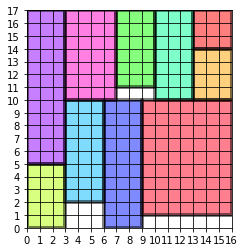

In [347]:
visualize(w, h, n, dims, coords)